In [3]:
import os
import shutil
directory = '/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data/experiment_results'
subject1 = 'experiment_result_JayShenoy'
subject2 = 'experiment_result_TaeSung'
subject3 = 'experiment_result_Xiangyu'
scenario_list = ['scenario1','scenario2','scenario3','scenario4','scenario5']

for scenario_name in scenario_list:
    dir1 = os.path.join(directory, subject1, scenario_name)
    dir2 = os.path.join(directory, subject2, scenario_name)
    dir3 = os.path.join(directory, subject3, scenario_name)

    files1 = set([file for file in os.listdir(dir1) if file.endswith('.jpg')])
    files2 = set([file for file in os.listdir(dir2) if file.endswith('.jpg')])
    files3 = set([file for file in os.listdir(dir3) if file.endswith('.jpg')])
    
    intersect = files1.intersection(files2.intersection(files3))
    print(len(intersect))
    
#     if not os.path.isdir(os.path.join(directory, scenario_name+'_intersection')):
#         os.mkdir(os.path.join(directory, scenario_name+'_intersection'))
    
#     for file in intersect:
#         shutil.copy(os.path.join(dir1, file), os.path.join(directory, scenario_name+'_intersection'))

42
6
0
2
0


In [4]:
from scenic.simulators.carla.nusc_query_api import NuscQueryAPI
nusc = NuscQueryAPI(version='v1.0-trainval', \
                    dataroot='/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data')

Loading NuScenes tables for version v1.0-trainval...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
34149 lidarseg,
Done loading in 48.227 seconds.
Reverse indexing ...
Done reverse indexing in 14.9 seconds.


In [25]:
from scenic.core.vectors import OrientedVector, Vector
import matplotlib.pyplot as plt
from scenic.core.type_support import toVector
from scenic.core.regions import PolygonalRegion, PointInRegionDistribution, SectorRegion
import os.path as path
from scenic.core.regions import SectorRegion
from scenic.core.geometry import triangulatePolygon, normalizeAngle
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from scenic.core.distributions import *
import math
import subprocess
import os


# TODO : need to handle jointly dependent objs as well
def isFeatureValid(feature, label, smt_file_path, cached_variables, featureType, debug=False, falseTesting=False):
    
    # TODO : need to handle jointly dependent objs as well
    if os.path.isfile(smt_file_path):
        os.remove(smt_file_path)
    
    open(smt_file_path, 'w').close()
    writeSMTtoFile(smt_file_path, '(set-logic QF_NRA)')

    # Instantiate cached_variables dictionary
    x, y, label_feature = None,None,None
    
    if not falseTesting:
        if featureType == 'position':
            label_feature = (str(label.x), str(label.y))
        if featureType == 'heading':
            label_feature = str(label)
    else:
        x = 1144.11438466291
        y = 1085.6681557273737
        heading = -0.293950447126917
        if featureType == 'position':
            label_feature = (str(x), str(y))
        
        
    # Encode object's position to SMT formula
    smt_var = feature.encodeToSMT(smt_file_path, cached_variables, debug = debug)
    
    if featureType == 'position':
        (x_cond, y_cond) = vector_operation_smt(label_feature, "equal", smt_var)
        writeSMTtoFile(smt_file_path, smt_assert(None, smt_and(x_cond, y_cond)))
    else:
        writeSMTtoFile(smt_file_path, smt_assert(None, smt_equal(label_feature, smt_var)))
    writeSMTtoFile(smt_file_path, "(check-sat)")
    writeSMTtoFile(smt_file_path, "(exit)")

    if not debug:
        if subprocess.call("./run_smt_encoding.sh") == 1:
            return True
        else:
            return False
    else:
        print("DEBUG MODE: NO OUTPUT WILL BE RETURNED")
            
    return None

def validateLabelTesting(scenario, debug=False, falseTesting=False):
    ego_visibleDistance = 10 #meters
    ego_viewAngle = 135 #deg
    smt_file_path = './test_smt_encoding.smt2'
    
    resetScenarioDependency(scenario)
    
    if not falseTesting:
        sample = scenario.generate()
        scene = sample[0]
        label_ego_pos = scene.objects[0].position
        label_ego_heading = scene.objects[0].heading
    else:
        x = 1144.11438466291
        y = 1085.6681557273737
        label_ego_pos = Vector(x,y)
        label_ego_heading = -0.293950447126917
    
    # Create Ego's VisibleRegion
    cached_variables = {}
    cached_variables['variables'] = []
    egoVisibleRegion = SectorRegion(label_ego_pos, ego_visibleDistance, label_ego_heading, \
                                    math.radians(ego_viewAngle))
    cached_variables['egoVisibleRegion'] = egoVisibleRegion

    for i in range(len(scenario.objects)):
        print("i: ",i)
        obj = scenario.objects[i]
        label_feature = scene.objects[i].position
        print("position: ", label_feature)
        feature = obj.position
        if isFeatureValid(feature, label_feature, smt_file_path,cached_variables, featureType='position', \
                          debug=debug, falseTesting=falseTesting):
            print("position is valid")
            # condition the validated feature with the label's feature
            feature.conditionTo(label_feature)
        else:
            print("NOT VALID: POSITION")
            return False

        label_feature = scene.objects[i].heading
        print("heading: ", label_feature)
        feature = obj.heading
        if isFeatureValid(feature, label_feature, smt_file_path, cached_variables, featureType='heading', \
                          debug=debug, falseTesting=falseTesting): 
            print("heading is valid")
            # condition the validated feature with the label's feature
            feature.conditionTo(Constant(label_feature))
        else:
            print("NOT VALID: HEADING")
            return False
        
    ## Check Hard Constraint Satisfaction
    if not scenario.checkRequirements():
        return False
    
    return True 


def validateLabel(scenario, img_name, debug=False, falseTesting=False, scenic_testing=False):
    ego_visibleDistance = 100 #meters
    ego_viewAngle = 120 #deg
    smt_file_path = './test_smt_encoding.smt2'
    
    resetScenarioDependency(scenario)
    
    label, ego_label, vehicles_label, pedestrians_label = None, None, None, None
    if not scenic_testing:
        label = nusc.get_img_data(img_name)
        ego_label = label['EgoCar']
        vehicles_label = label['Vehicles']
        pedestrians_label = label['Pedestrians']
        (x_ego, y_ego) = ego_label['position']
        label_ego_pos = Vector(x_ego, y_ego)
#         label_ego_heading = normalizeAngle(math.radians(label['EgoCar']['heading']+90))
        label_ego_heading = math.radians(label['EgoCar']['heading']+90)
        
    else:
        if not falseTesting:
            sample = scenario.generate()
            label = sample[0]
            ego_label = label.objects[0]
            vehicles_label = [label.objects[i+1] for i in range(len(label.objects)-1)]
            label_ego_pos = ego_label.position
            label_ego_heading = ego_label.heading
        else:
            x = 1144.11438466291
            y = 1085.6681557273737
            label_ego_pos = Vector(x,y)
            label_ego_heading = -0.293950447126917
    
    # Create Ego's VisibleRegion
    cached_variables = {}
    cached_variables['variables'] = []
    egoVisibleRegion = SectorRegion(label_ego_pos, ego_visibleDistance, label_ego_heading, \
                                    math.radians(ego_viewAngle))
    cached_variables['egoVisibleRegion'] = egoVisibleRegion
    
    ## Validate EgoCar label
    if not checkPosHeading(scenario.objects[0], ego_label, smt_file_path, cached_variables, \
                           debug, falseTesting, scenic_testing):
        return False
    
    ## Validate Other agents' labels
    # create a permutation of all label's Vehicles
    obj_labels = None
    if 'Pedestrian' in str(scenario.objects[1]):
        print("PERMUTING PEDESTRIANS")
        if len(pedestrians_label)==0:
            print("NO PEDESTRIAN AVAILABLE!")
            return False
        permutation = permutedIndexSet(pedestrians_label)
        obj_labels = pedestrians_label
    else:
        print("PERMUTING VEHICLES")
        permutation = permutedIndexSet(vehicles_label)
        obj_labels = vehicles_label
    feasible_permutation = permutation
    
    valid = False
    # try permutations of label matching
    for p in permutation:
        if p not in feasible_permutation:
            continue
            
        (boolean, failed_permutation) = tryPermutation(p, obj_labels, scenario, smt_file_path, \
                                                       cached_variables, debug, falseTesting, scenic_testing)
        if not boolean:
            feasible_permuation = removeInfeasiblePermutation(failed_permutation, permutation)
            # Need reset conditioned objects with wrong permutation of labels
            resetScenarioDependency(scenario)
            # reset cached_variables dictionary
            resetDictionary(cached_variables, egoVisibleRegion)
            # Ego's label is valid so keep that conditioned obj
            checkPosHeading(scenario.objects[0], label['EgoCar'], smt_file_path, cached_variables, \
                           debug, falseTesting)
        else:
            valid = True
            break
    
    if not valid:
        return False
            
    ## Check Hard Constraint Satisfaction
    if not scenario.checkRequirements():
        return False
    return True 

def tryPermutation(permutation_tuple, label_objs, scenario, smt_file_path, cached_variables, \
                           debug=False, falseTesting=False, scenic_testing=False):
    failed_index_sequence = []
    for i in range(len(scenario.objects)-1):
        index = permutation_tuple[i]
        
        label_obj = label_objs[index]
        scenic_obj= scenario.objects[i+1]
        if checkPosHeading(scenic_obj, label_obj, smt_file_path, cached_variables, \
                           debug, falseTesting, scenic_testing):
            failed_index_sequence.append(index)
        else:
            failed_index_sequence.append(index)
            return (False, failed_index_sequence)
    return (True, None)
    
def checkPosHeading(scenic_obj, label_obj, smt_file_path, cached_variables, debug=False, falseTesting=False,\
                   scenic_testing=False):
    if not scenic_testing:
        (x,y) = label_obj['position']
    else:
        (x,y) = label_obj.position
        
    label_feature = Vector(x,y)
    print("position: ", label_feature)
    feature = scenic_obj.position
    if isFeatureValid(feature, label_feature, smt_file_path, cached_variables, \
                      featureType='position', \
                      debug=debug, falseTesting=falseTesting):
        print("POSITION IS VALID")
        # condition the validated feature with the label's feature
        feature.conditionTo(label_feature)
    else:
        print("NOT VALID: POSITION")
        return False

    if not scenic_testing:
        heading = label_obj['heading'] + 90
        label_feature = math.radians(heading)
    else:
        heading = label_obj.heading
        label_feature = heading
    print("heading: ", label_feature)
    feature = scenic_obj.heading
    if isFeatureValid(feature, label_feature, smt_file_path, cached_variables, \
                      featureType='heading', \
                      debug=debug, falseTesting=falseTesting): 
        print("heading is valid")
        # condition the validated feature with the label's feature
        feature.conditionTo(Constant(label_feature))
    else:
        print("NOT VALID: HEADING")
        return False
    return True

def permutedIndexSet(label_objs):
    index_list = [i for i in range(len(label_objs))]
    return set(itertools.permutations(index_list))

# def permutedIndexSetTesting(index_list):
# #     index_list = [i for i in range(len(label['Vehicles']))]
#     return set(itertools.permutations(index_list))

def removeInfeasiblePermutation(failed_list, permutation_set):
    infeasible_permutation = set()
    for p_tuple in permutation_set:
        if tupleStartsWith(failed_list, p_tuple):
            infeasible_permutation.add(p_tuple)
    return permutation_set.difference(infeasible_permutation)
            
def tupleStartsWith(failed_list, permutation_tuple):
    for i in range(len(failed_list)):
        if failed_list[i] != permutation_tuple[i]:
            return False
    return True

def resetDictionary(cached_variables, egoVisibleRegion):
    cached_variables = {}
    cached_variables['variables'] = []
    cached_variables['egoVisibleRegion'] = egoVisibleRegion
        
def resetScenarioDependency(scenario):
    for obj in scenario.objects:
        resetConditionedVar(obj.position)
        resetConditionedVar(obj.heading)

def resetConditionedVar(obj):
    obj._conditioned = obj
    if (obj._dependencies is None):
        return None
    for dep in obj._dependencies:
        resetConditionedVar(dep)
    return None

# directory = '/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data/experiment_folder/experiment'
# filenames = os.listdir(directory)
# print("label validity: ", validateLabel(scenario, filenames[0] ,debug=False, falseTesting=False, scenic_testing=True))


In [26]:
import os
import scenic
scenic_script = "./examples/carla/experiment5.scenic"
scenario = scenic.scenarioFromFile(scenic_script)

76
position:  (770.0659171415182 @ 421.2352666163001)


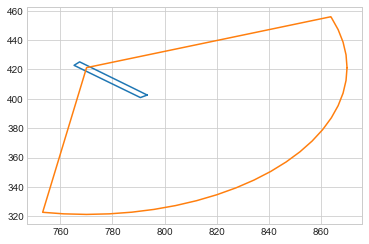

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


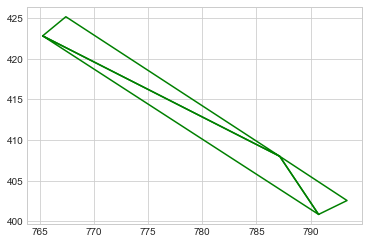

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


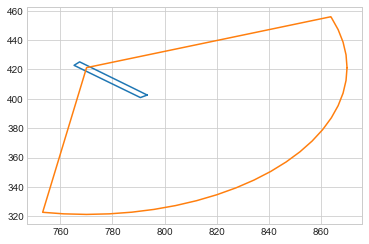

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


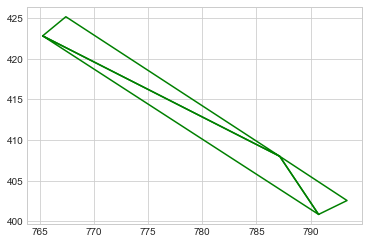

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


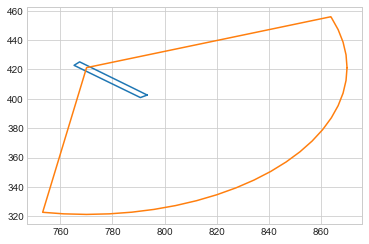

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


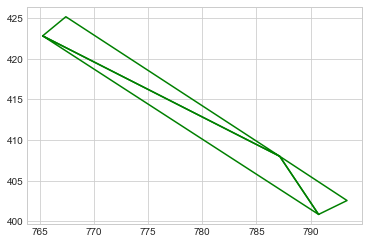

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


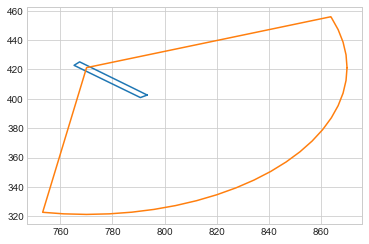

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


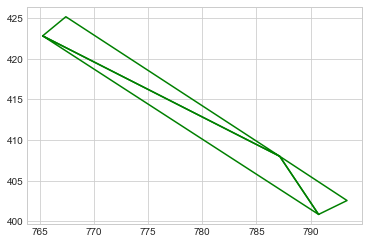

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


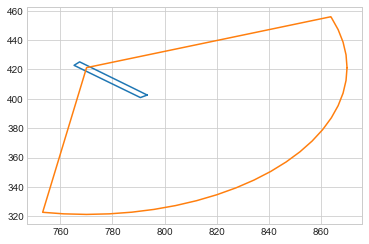

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


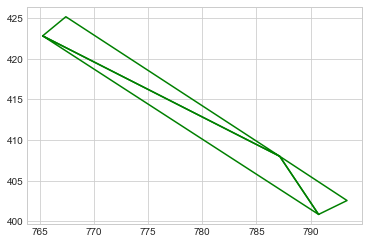

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


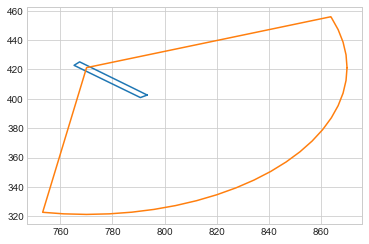

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


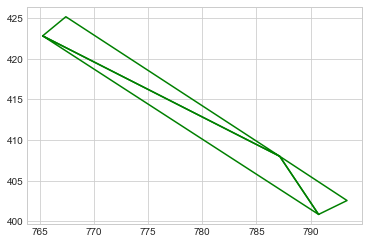

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


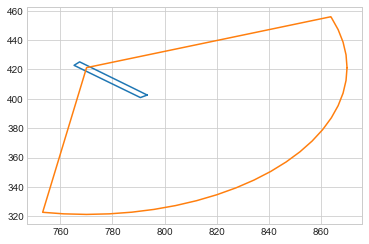

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


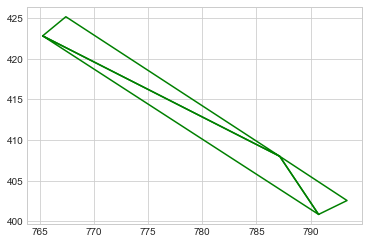

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


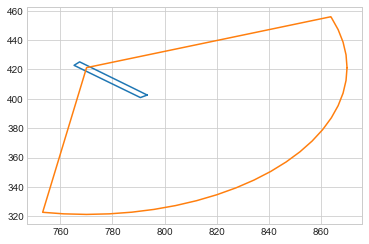

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


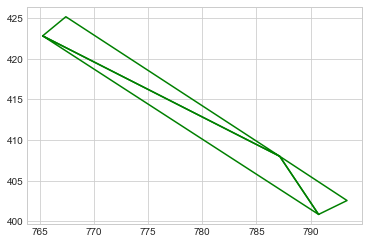

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


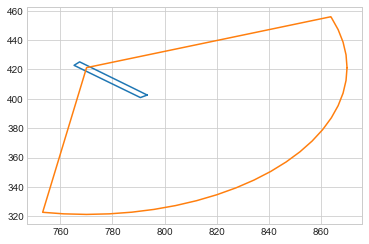

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


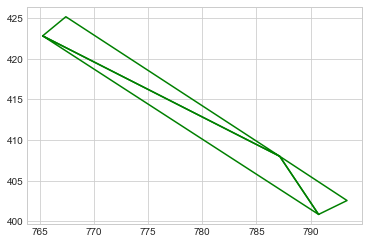

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


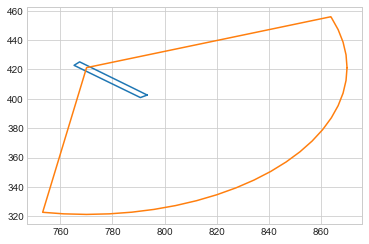

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


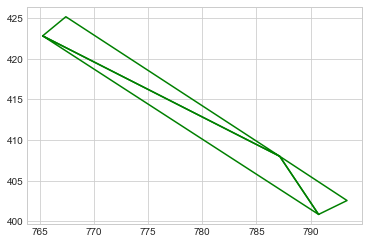

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


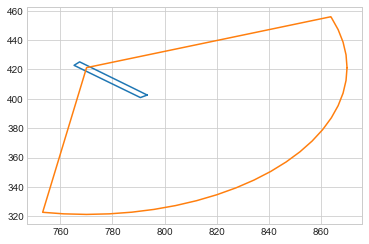

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


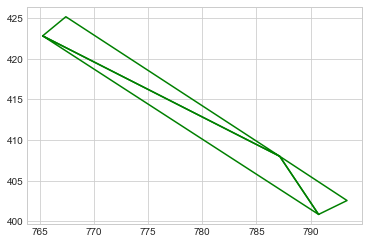

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


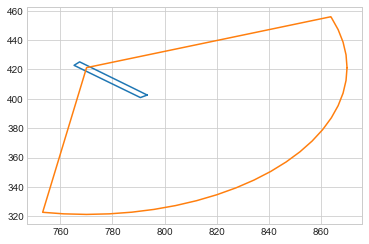

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


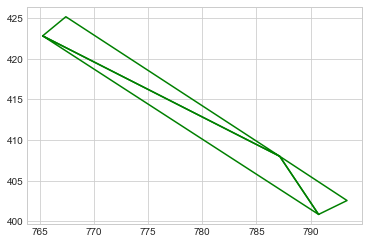

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


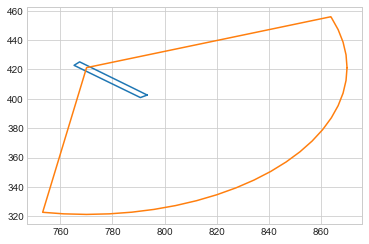

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


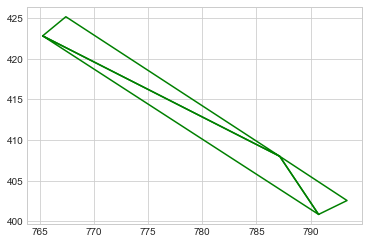

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


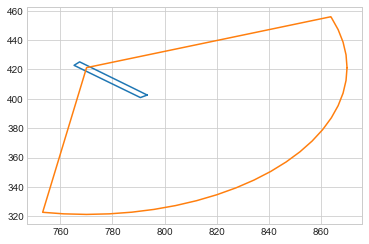

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


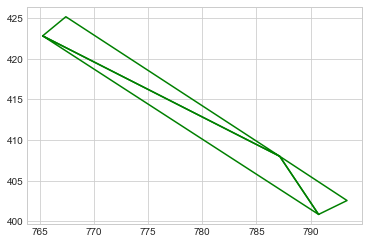

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


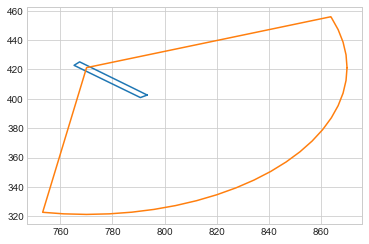

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


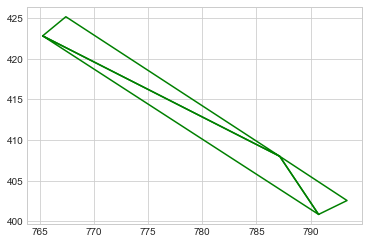

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


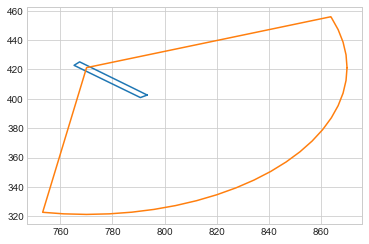

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


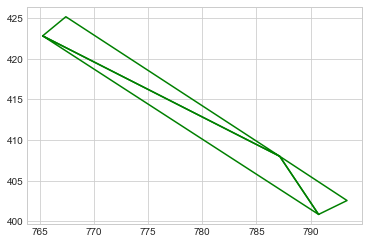

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


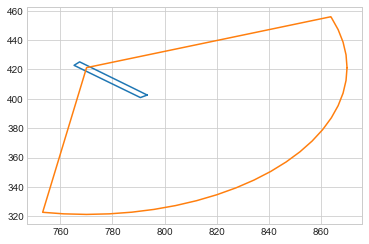

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


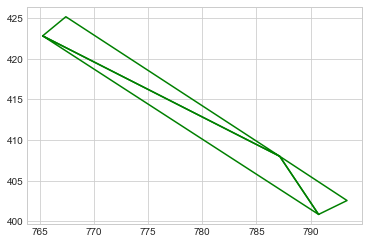

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


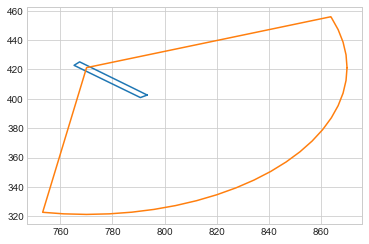

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


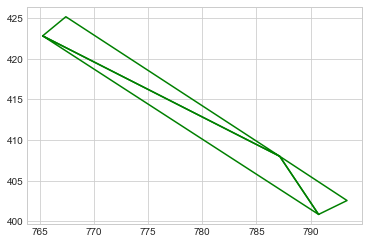

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


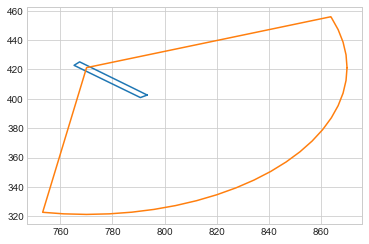

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


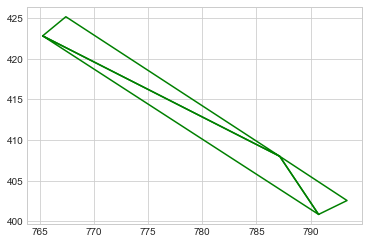

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


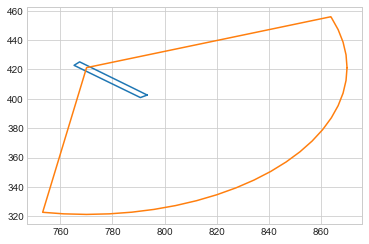

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


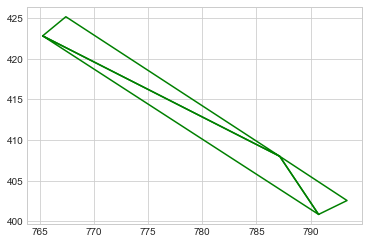

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


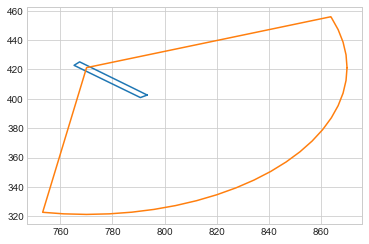

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


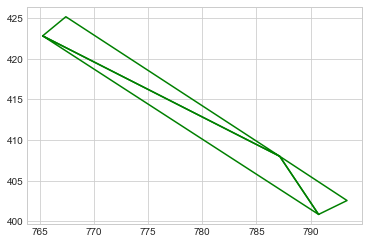

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


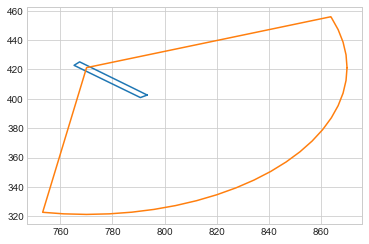

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


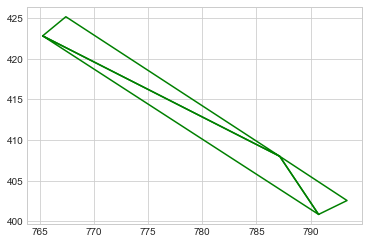

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


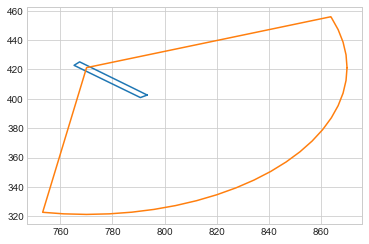

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


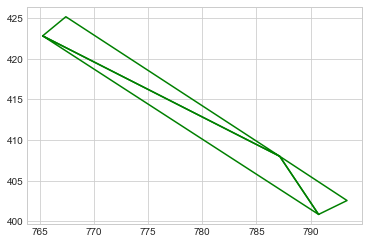

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


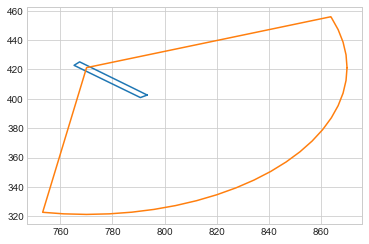

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


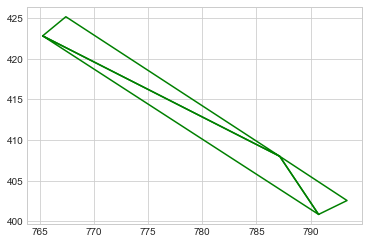

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


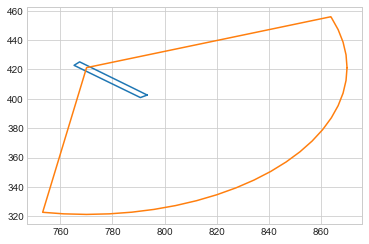

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


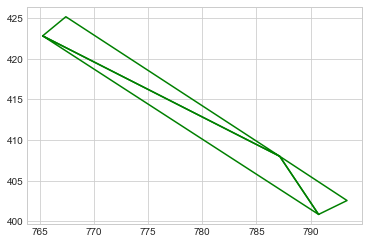

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


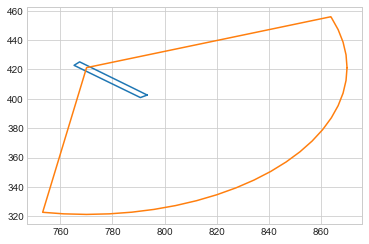

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


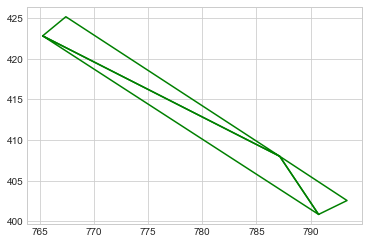

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


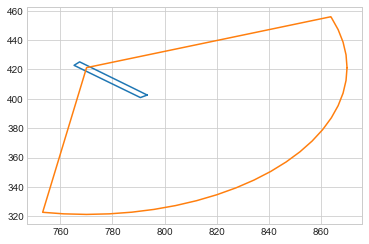

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


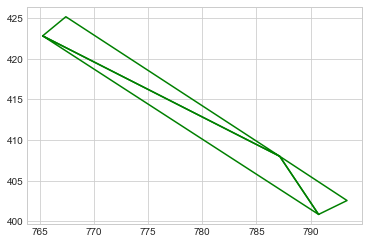

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


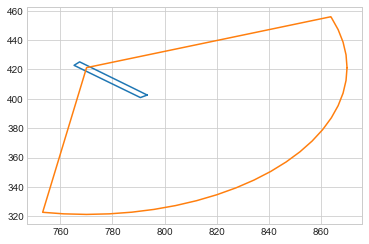

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


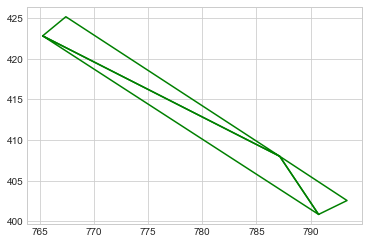

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


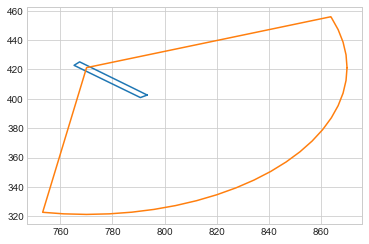

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


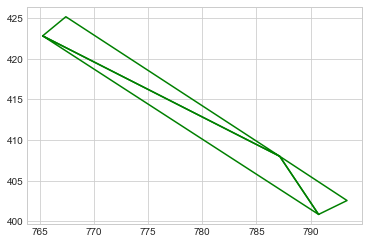

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


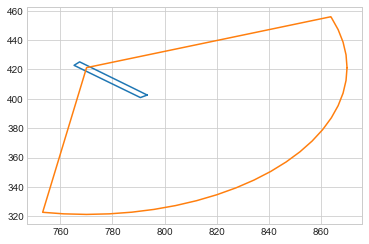

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


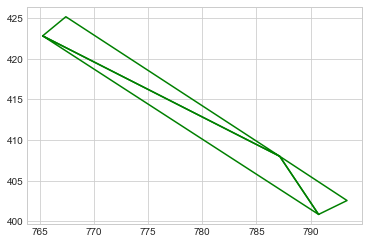

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


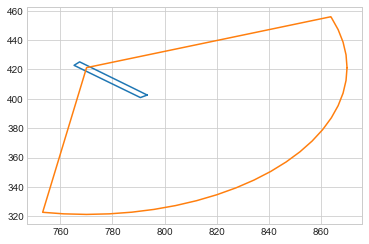

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


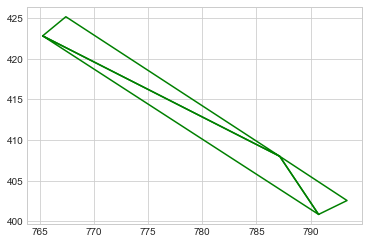

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


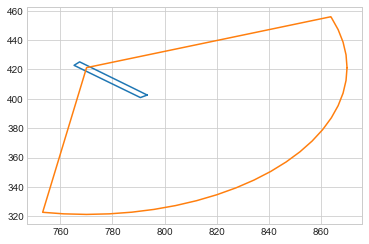

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


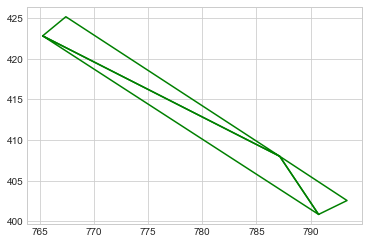

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


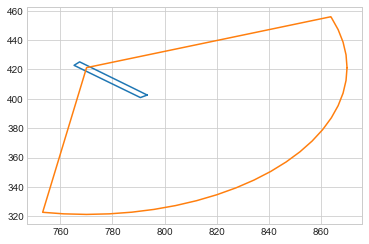

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


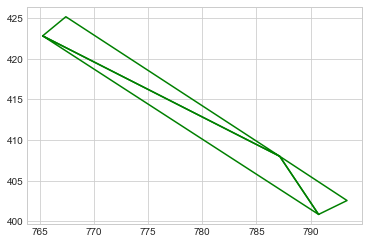

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


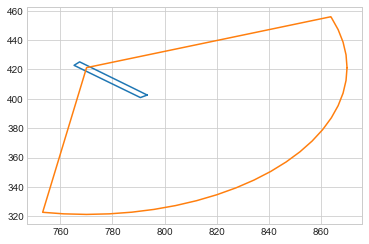

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


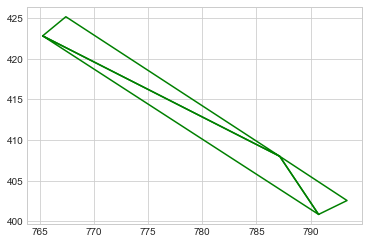

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


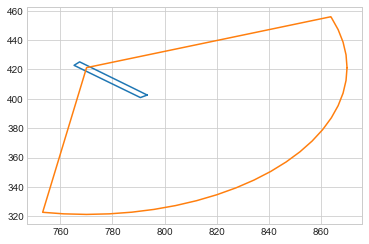

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


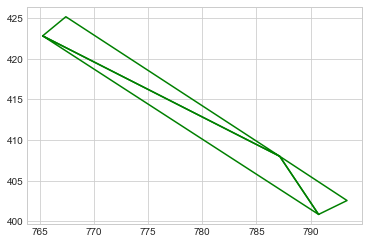

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


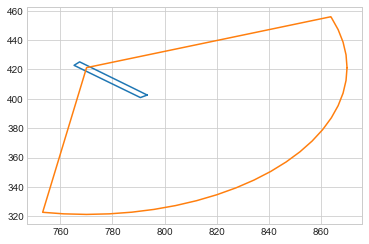

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


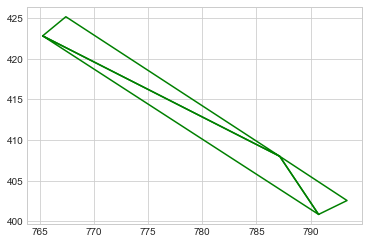

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


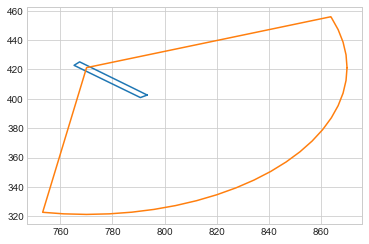

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


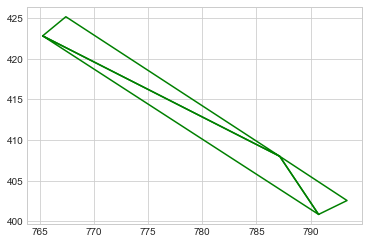

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


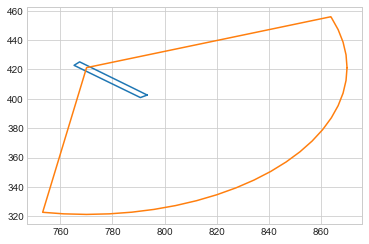

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


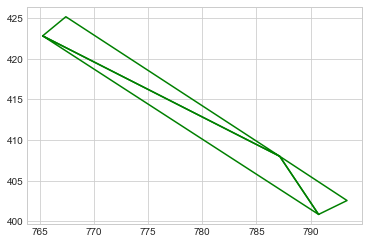

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


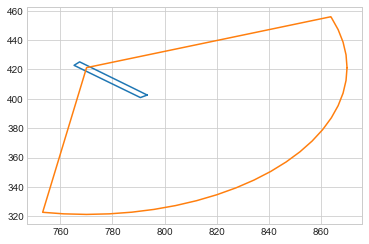

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


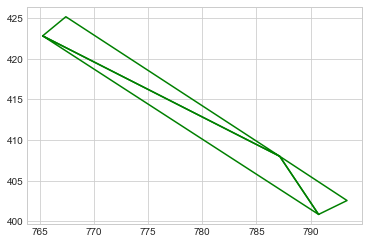

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


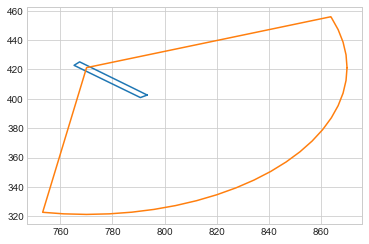

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


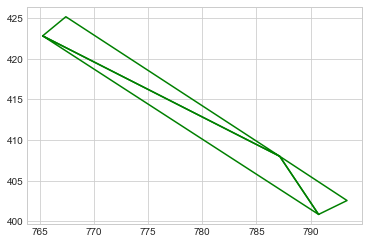

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


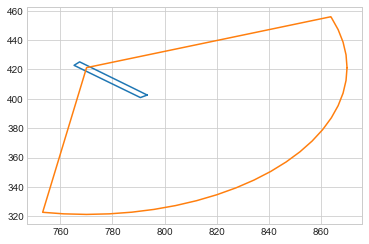

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


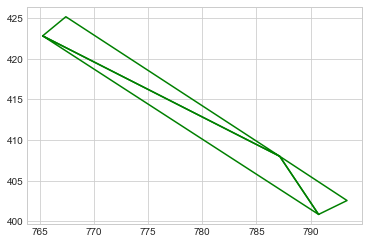

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


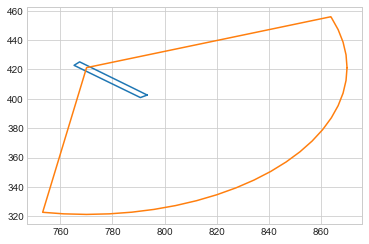

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


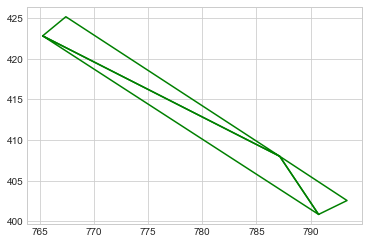

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


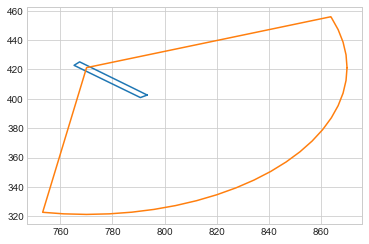

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


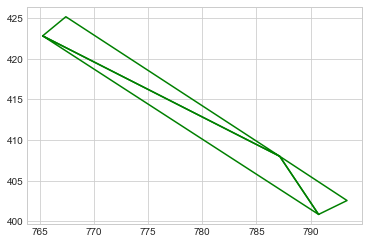

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


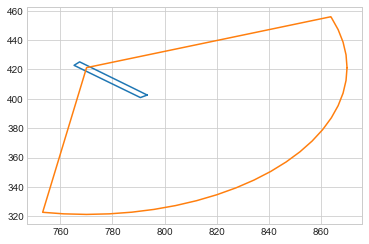

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


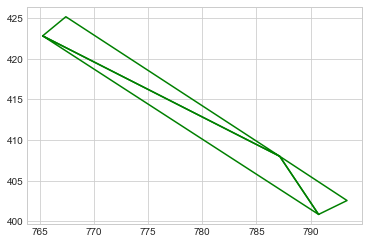

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


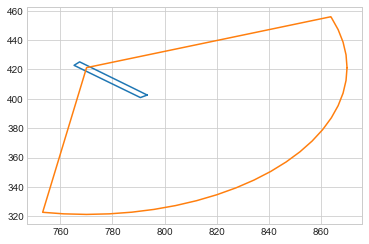

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


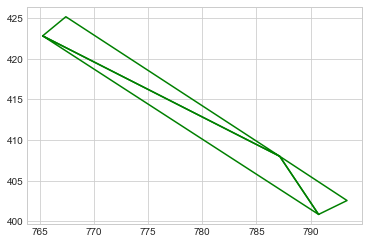

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


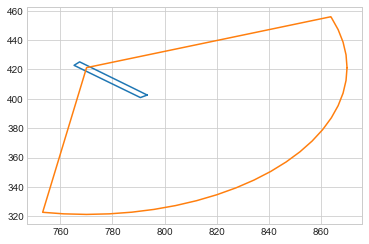

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


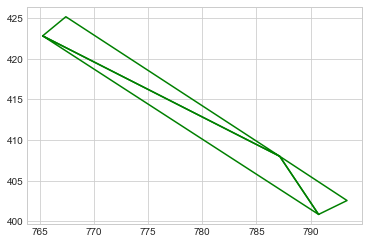

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


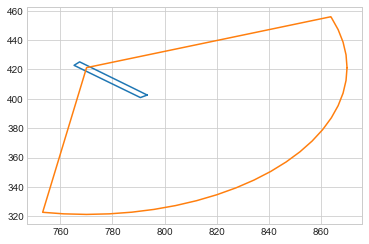

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


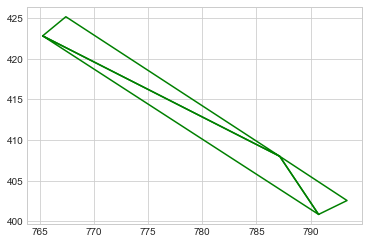

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


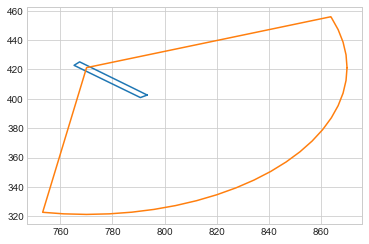

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


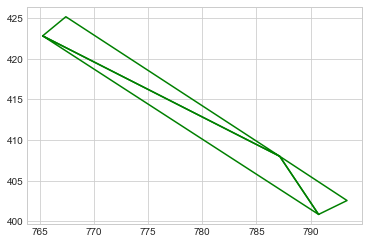

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


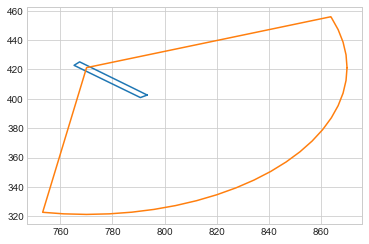

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


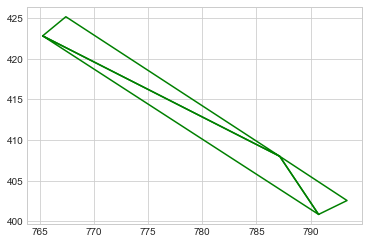

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


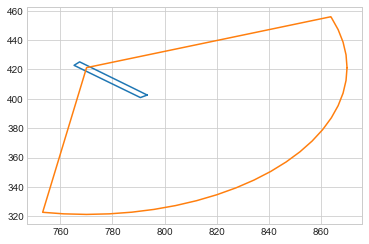

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


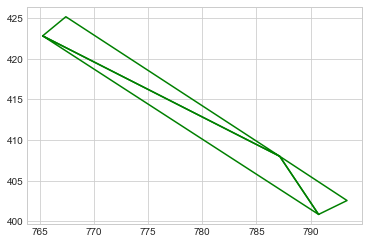

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


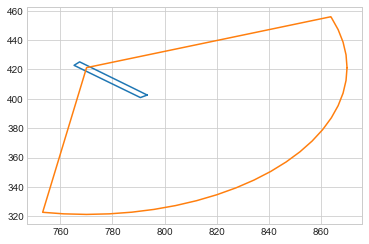

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


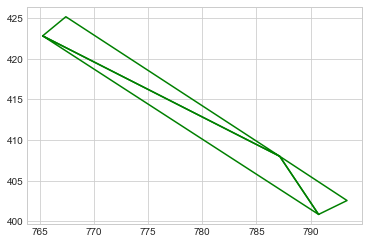

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


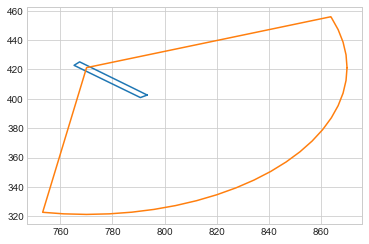

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


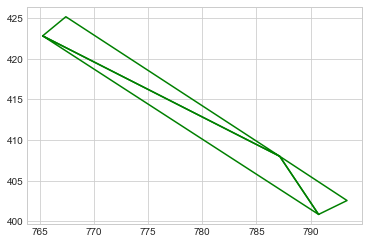

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


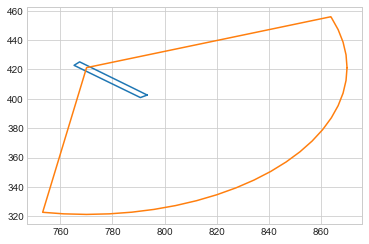

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


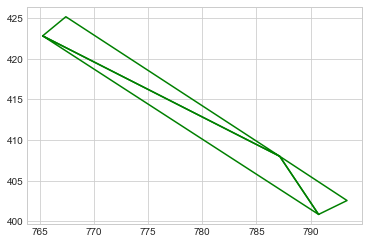

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


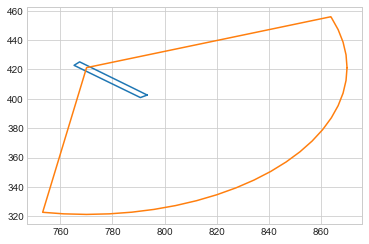

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


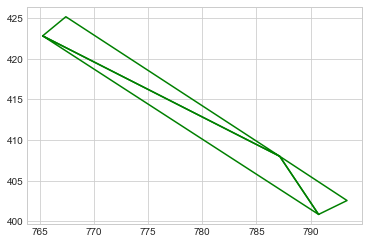

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


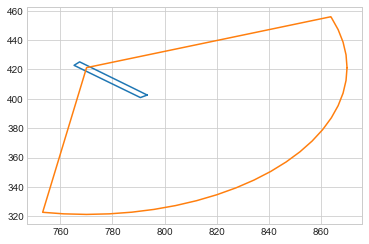

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


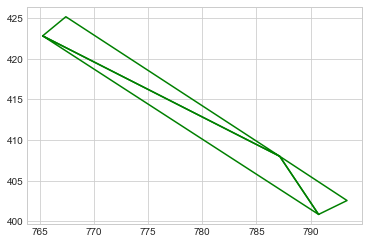

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


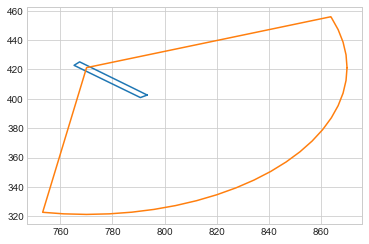

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


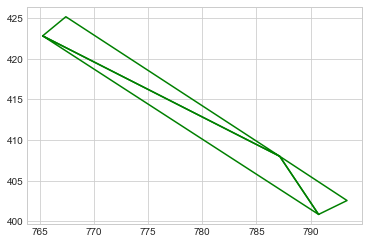

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


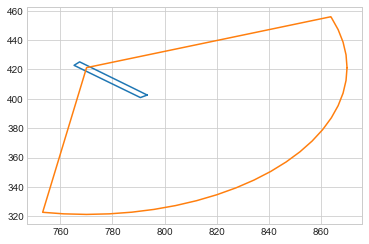

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


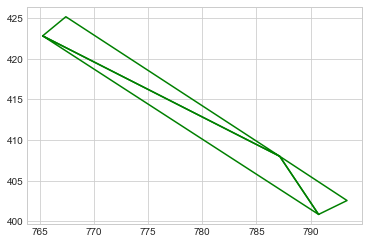

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


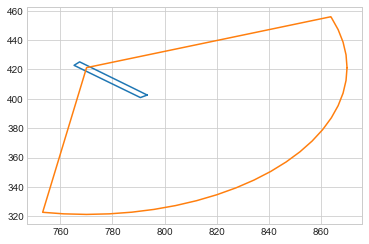

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


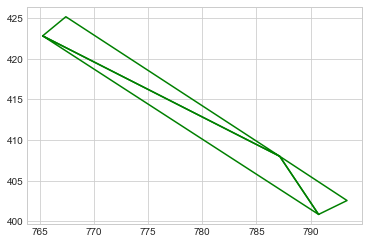

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


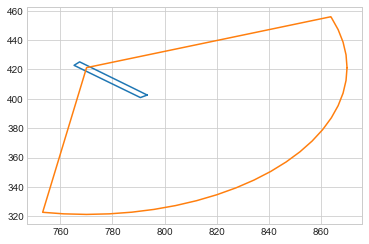

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


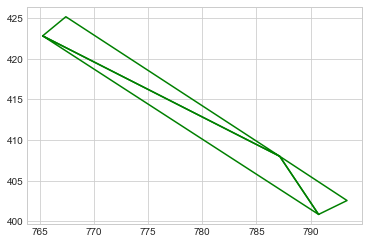

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


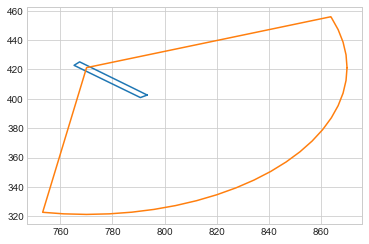

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


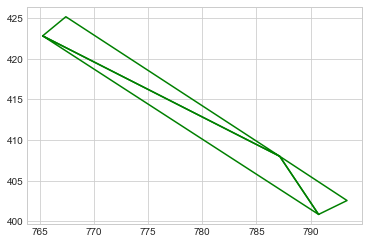

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


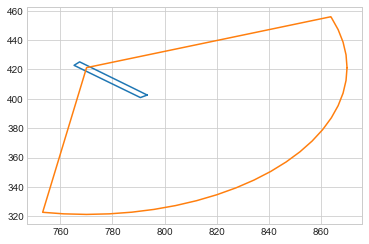

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


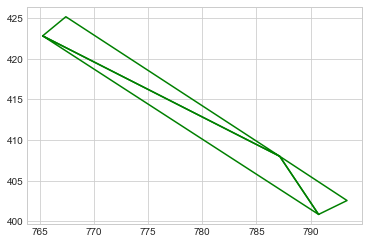

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


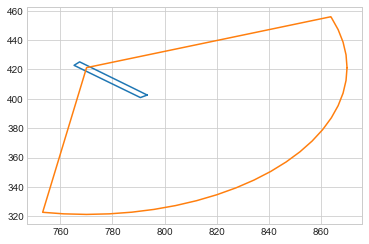

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


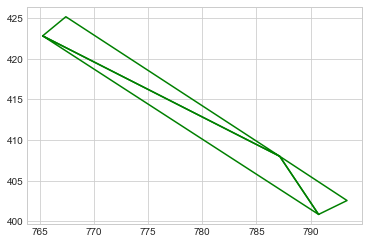

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


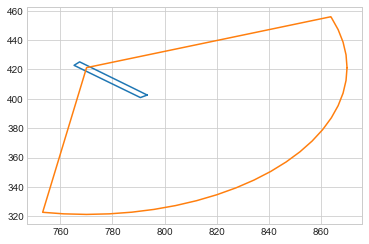

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


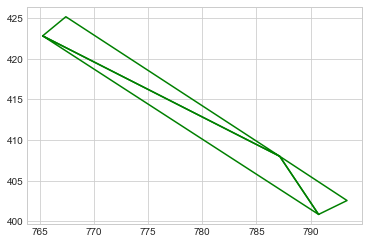

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


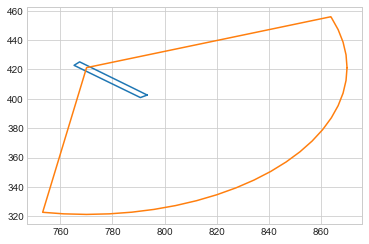

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


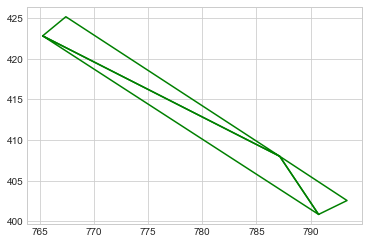

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


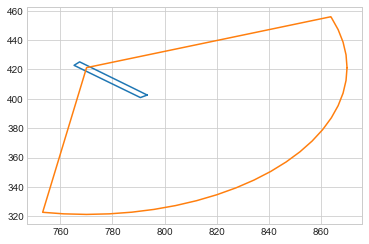

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


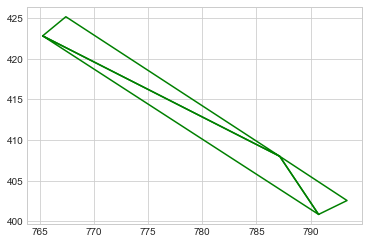

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


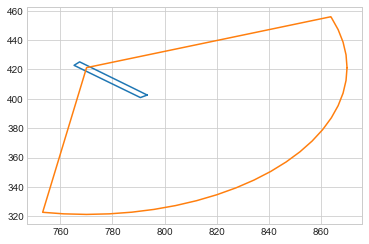

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


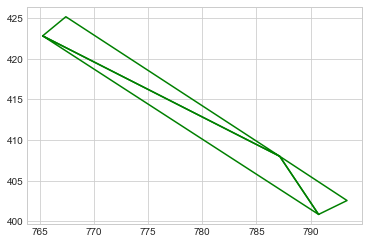

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


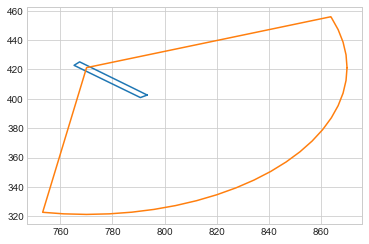

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


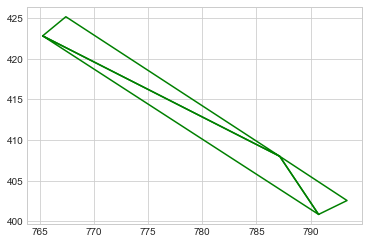

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


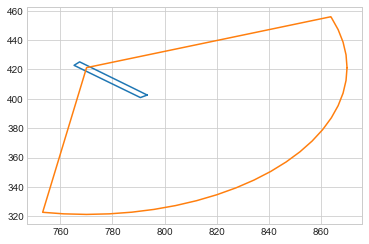

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


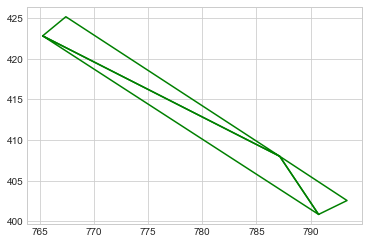

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


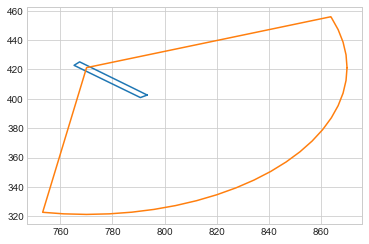

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


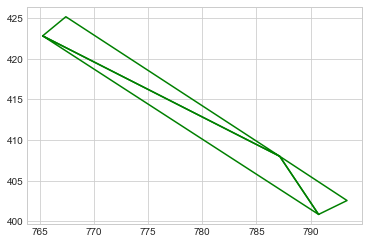

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


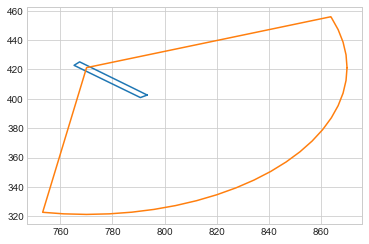

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


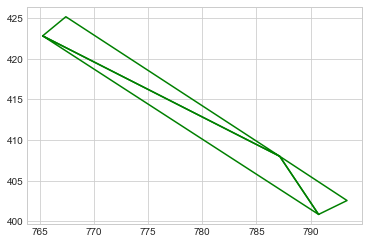

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


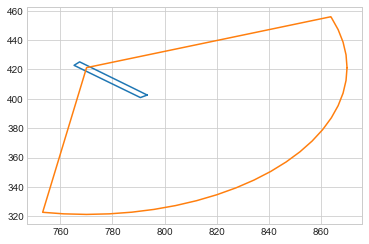

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


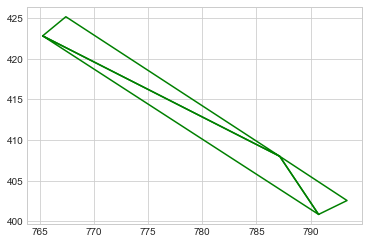

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


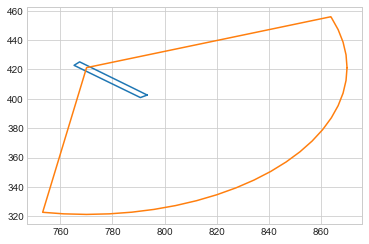

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


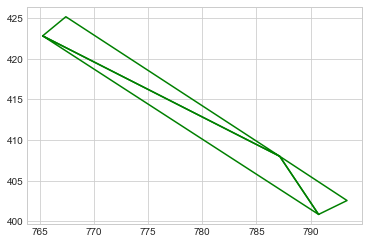

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


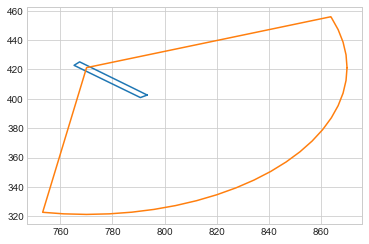

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


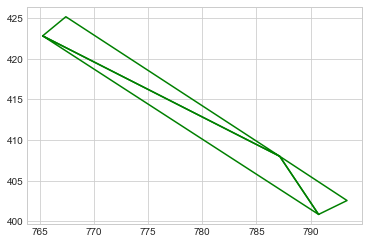

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


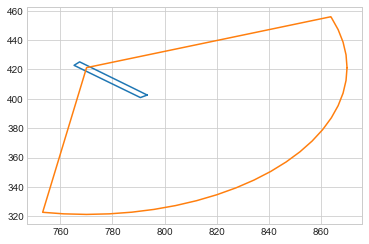

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


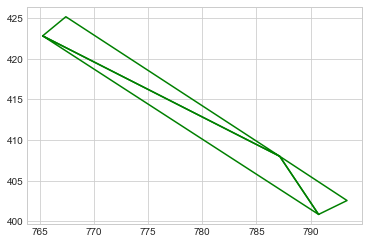

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


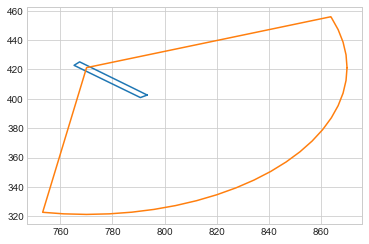

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


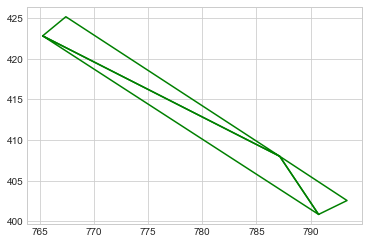

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False
position:  (770.0659171415182 @ 421.2352666163001)


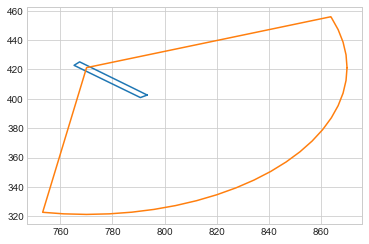

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x3209c8a00>]


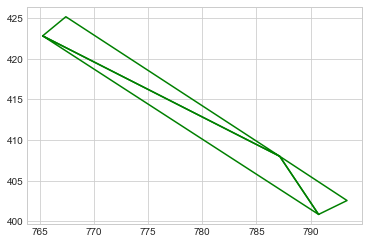

POSITION IS VALID
heading:  4.019434680828833
heading is valid
PERMUTING VEHICLES
position:  (761.777 @ 434.252)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
position:  (744.979 @ 441.731)
NOT VALID: POSITION
position:  (770.0659171415182 @ 421.2352666163001)
NOT VALID: POSITION
VALID:  False


In [30]:
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

directory = '/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data/experiment_results'
subject1 = 'experiment_result_JayShenoy'
subject2 = 'experiment_result_TaeSung'
subject3 = 'experiment_result_Xiangyu'
scenario_list = ['scenario1','scenario2','scenario3','scenario4','scenario5']

dir3 = os.path.join(directory, 'scenario5_queried')
# dir3 = os.path.join(directory, subject3, 'scenario3')
filenames = [file for file in os.listdir(dir3) if file.endswith('.jpg')]
print(len(filenames))

query_directory = os.path.join(directory, 'scenario5_queried_refined')
if not os.path.isdir(query_directory):
    os.mkdir(query_directory)

for file in filenames:
    file = filenames[0]
    valid = validateLabel(scenario, file, debug=False, falseTesting=False, scenic_testing=False)
    print("VALID: ", valid)
    if valid:  
        shutil.copy(os.path.join(dir3, file), query_directory)
        img = mpimg.imread(os.path.join(dir3, file))
        imgplot = plt.imshow(img)
        plt.show()
    

In [16]:
scenario.objects[0].position.region._conditioned.options

(<LaneSection at 0x1349fb3a0; uid="0f98559f-b844-424a-bfc5-8f8b19aa3724_sec">,
 <LaneSection at 0x1353456d0; uid="8439a11e-d345-4a34-9a11-11c5fc296f5d_sec">,
 <LaneSection at 0x135028610; uid="a0fac7f4-0801-425e-93d4-c51dfba06785_sec">,
 <LaneSection at 0x134579130; uid="6e77c8fe-79aa-4d8a-8b49-45845992f78d_sec">,
 <LaneSection at 0x1339c6070; uid="1278955c-6c11-4705-9dd6-b9f65377711f_sec">,
 <LaneSection at 0x133087f10; uid="b6bef143-5046-4791-900d-ac8a02988ddb_sec">,
 <LaneSection at 0x132e7b0d0; uid="87daaf18-2b40-4e80-b078-82db3e1cc101_sec">,
 <LaneSection at 0x132392fa0; uid="713e3272-924d-46af-8d9d-652095619e0e_sec">,
 <LaneSection at 0x132419340; uid="68fac1dc-12e7-4cfa-b8b0-fc5903a9adae_sec">,
 <LaneSection at 0x1318830a0; uid="b8df0539-248d-42f2-b39e-0d26b0376072_sec">,
 <LaneSection at 0x131831940; uid="9c2f05f6-2d79-4eb4-85ea-b89af711b885_sec">,
 <LaneSection at 0x13114c430; uid="07765ab7-77ba-4e54-ab58-7fcfca05706f_sec">,
 <LaneSection at 0x1310dee20; uid="a4124c18-6ac2-4a2